In [1]:
import pandas as pd
import numpy as np
import torch
from better_kan import *
import copy


seed = 0
torch.manual_seed(seed)
np.random.seed(seed)

dtype = torch.get_default_dtype()

# Download data: https://colab.research.google.com/github/deepmind/mathematics_conjectures/blob/main/knot_theory.ipynb#scrollTo=l10N2ZbHu6Ob
df = pd.read_csv("C:\\Users\\18816\\Downloads\\knot_theory_invariants.csv")
df.keys()

X = df[df.keys()[1:]].to_numpy()
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)
X = (X - mean[np.newaxis,:])/std[np.newaxis,:]

# normalize X
X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)
X = (X - X_mean[np.newaxis,:])/X_std[np.newaxis,:]
input_normalier = [X_mean, X_std]

dataset = {}
num = X.shape[0]
n_feature = X.shape[1]
train_ratio = 0.8
train_id_ = np.random.choice(num, int(num*train_ratio), replace=False)
test_id_ = np.array(list(set(range(num))-set(train_id_)))
dataset['train_input'] = torch.from_numpy(X[train_id_]).type(dtype)
dataset['test_input'] = torch.from_numpy(X[test_id_]).type(dtype)

def construct_contrastive_dataset(tensor):
    y = copy.deepcopy(tensor)
    for i in range(y.shape[1]):
        y[:,i] = y[:,i][torch.randperm(y.shape[0])]
    return y

dataset['contrastive_train_input'] = construct_contrastive_dataset(dataset['train_input'])
dataset['contrastive_test_input'] = construct_contrastive_dataset(dataset['test_input'])

dataset['train_label'] = torch.cat([torch.ones(dataset['train_input'].shape[0],1), torch.zeros(dataset['contrastive_train_input'].shape[0],1)], dim=0)
dataset['train_input'] = torch.cat([dataset['train_input'], dataset['contrastive_train_input']], dim=0)

dataset['test_label'] = torch.cat([torch.ones(dataset['test_input'].shape[0],1), torch.zeros(dataset['contrastive_test_input'].shape[0],1)], dim=0)
dataset['test_input'] = torch.cat([dataset['test_input'], dataset['contrastive_test_input']], dim=0)


In [2]:
def train_acc():
    return torch.mean(((model(dataset['train_input']) > 0.5) == dataset['train_label']).float())

def test_acc():
    return torch.mean(((model(dataset['test_input']) > 0.5) == dataset['test_label']).float())
# print(dataset['test_input'].shape)
model = KAN(width=[n_feature,1,1],num_basis=5)
model.fix_symbolic(1,0,0,'gaussian',fit_params_bool=False)
model.train(dataset, lamb=0.001, batch=1024, metrics=[train_acc, test_acc],lr=1);
print(test_acc(), train_acc())

train loss: 1.20e-01 | test loss: 1.58e-01 | reg: 1.35e+01 : 100%|█| 100/100 [01:54<00:00,  1.15s/it


tensor(0.9718) tensor(0.9720)


In [3]:
# y_eval=model(dataset['test_input'])
# plt.figure()
# plt.scatter(dat )

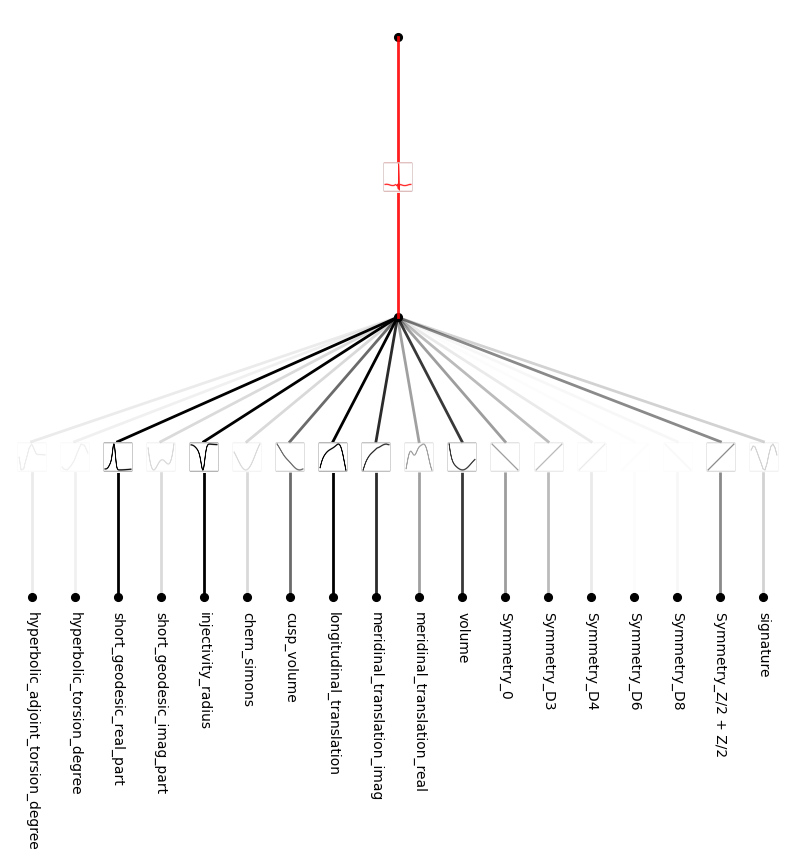

In [4]:
# seed = 2024
model.plot(scale=1.0)

n = 18
for i in range(n):
    plt.gcf().get_axes()[0].text(1/(2*n)+i/n-0.005,-0.02,df.keys()[1:][i], rotation=270, rotation_mode="anchor")

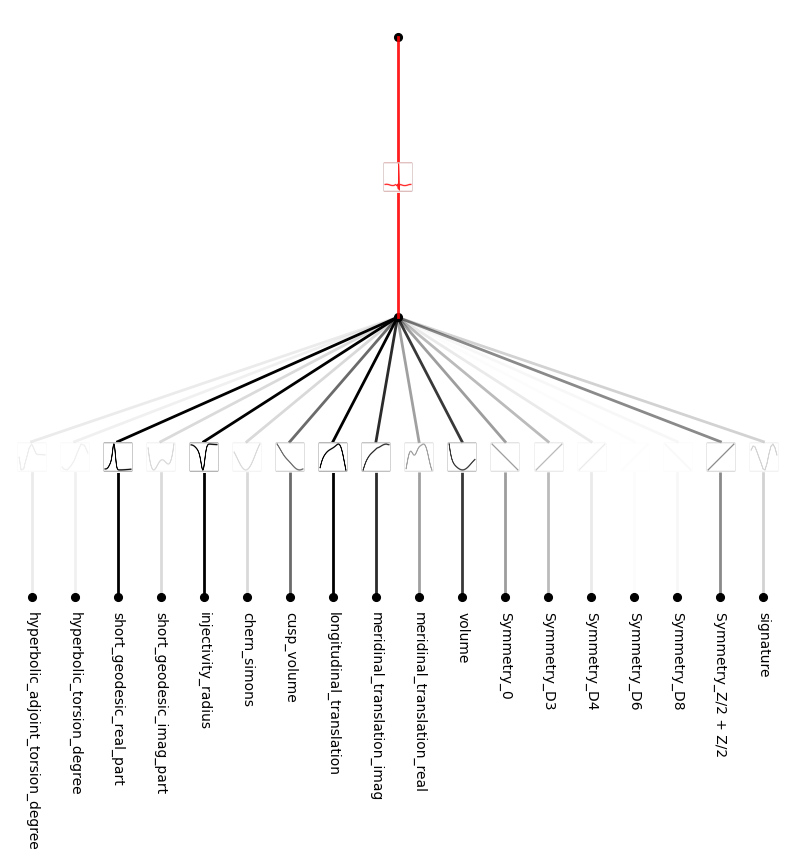

In [5]:
# seed = 0
model.plot(scale=1.0)

n = 18
for i in range(n):
    plt.gcf().get_axes()[0].text(1/(2*n)+i/n-0.005,-0.02,df.keys()[1:][i], rotation=270, rotation_mode="anchor")